In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *
from bnbsl import *

from classes import *
from utils import *

In [3]:
SEASON = '23'
set_seed(int(SEASON))

## Download HKJC odds

In [4]:
path_raw = Path('raw_data')
path_data = Path('data')

path_output = Path('output')

In [5]:
session = requests.Session()
r = session.get('http://bet.hkjc.com')
cookies = r.cookies

In [6]:
odds_url = 'https://bet.hkjc.com/football/getJSON.aspx?jsontype=odds_chl.aspx'
response = session.post(
    odds_url,
    headers={'referer':'http://bet.hkjc.com'},
    cookies=cookies
)

In [7]:
with open(path_data/'json'/f'odds_chl-{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}.txt', 'w') as f:
    f.write(response.text)

In [8]:
matches_json = json.loads(response.text)['matches']

In [9]:
# Example
# matches_json = json.loads(open(path_data/'json'/'odds_chl-2021-11-20-20-15-14.txt').read())[1]['matches']

In [10]:
matches = [Match(m) for m in matches_json if m['matchStatus'] == 'Defined']
odds = [m.export() for m in matches]

['20240329FRIFB3713', '2024-Mar-29', '04:57:00', 'Chilean Division 1 [CD1]', 'Audax Italiano', 'Coquimbo Unido', 'true', '10.5', '1.94', '1.76', 'false', '11.5', '2.45', '1.48', 'false', '14.5', '5.40', '1.10']
['20240329FRIFB3716', '2024-Mar-29', '07:00:00', 'Argentine Division 1 [APL]', 'Rosario Central', 'Barracas Central', 'true', '9.5', '1.90', '1.80', 'false', '10.5', '2.45', '1.48', 'false', '12.5', '4.05', '1.18']
['20240329FRIFB3712', '2024-Mar-29', '07:27:00', 'Chilean Division 1 [CD1]', "O'Higgins", 'Iquique', 'true', '11.5', '2.22', '1.58', 'false', '12.5', '2.80', '1.37', 'false', '14.5', '4.75', '1.13']
['20240329FRIFB3735', '2024-Mar-29', '08:00:00', 'Argentine Division 1 [APL]', 'Instituto de Cordoba', 'Argentinos Juniors', 'true', '9.5', '2.00', '1.72', 'false', '10.5', '2.60', '1.43', 'false', '12.5', '4.30', '1.16']
['20240329FRIFB3690', '2024-Mar-29', '08:35:00', 'Brazilian Paulista League [BPC]', 'Palmeiras', 'Novorizontino', 'true', '10.5', '2.13', '1.63', 'false'

In [11]:
cols_match = ['MatchDay', 'Date', 'Time', 'LeagueJC', 'HomeTeamJC', 'AwayTeamJC']
cols_odds0 = ['MAINLINE_0', 'CHL_LINE_0', 'CHL_H_0', 'CHL_L_0']
cols_odds1 = ['MAINLINE_1', 'CHL_LINE_1', 'CHL_H_1', 'CHL_L_1']
cols_odds2 = ['MAINLINE_2', 'CHL_LINE_2', 'CHL_H_2', 'CHL_L_2']
cols_odds  = ['MAINLINE', 'CHL_LINE', 'CHL_H', 'CHL_L']
cols_pred  = ['alpha_1', 'alpha_2', 'mu_1', 'mu_2', 'omega', 'corr']

cols = cols_match + cols_odds0 + cols_odds1 + cols_odds2

In [12]:
odds = [o for o in odds if len(o) == 18]

In [13]:
odds = pd.DataFrame(odds, columns=cols)
odds = odds.fillna(value=np.nan)

In [14]:
cols_odds_ = cols_odds0[1:]+cols_odds1[1:]+cols_odds2[1:]
odds[cols_odds_] = odds[cols_odds_].astype(float)

In [15]:
odds

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE_0,CHL_LINE_0,CHL_H_0,CHL_L_0,MAINLINE_1,CHL_LINE_1,CHL_H_1,CHL_L_1,MAINLINE_2,CHL_LINE_2,CHL_H_2,CHL_L_2
0,20240329FRIFB3713,2024-Mar-29,04:57:00,Chilean Division 1 [CD1],Audax Italiano,Coquimbo Unido,true,10.5,1.94,1.76,false,11.5,2.45,1.48,false,14.5,5.40,1.10
1,20240329FRIFB3716,2024-Mar-29,07:00:00,Argentine Division 1 [APL],Rosario Central,Barracas Central,true,9.5,1.90,1.80,false,10.5,2.45,1.48,false,12.5,4.05,1.18
2,20240329FRIFB3712,2024-Mar-29,07:27:00,Chilean Division 1 [CD1],O'Higgins,Iquique,true,11.5,2.22,1.58,false,12.5,2.80,1.37,false,14.5,4.75,1.13
3,20240329FRIFB3735,2024-Mar-29,08:00:00,Argentine Division 1 [APL],Instituto de Cordoba,Argentinos Juniors,true,9.5,2.00,1.72,false,10.5,2.60,1.43,false,12.5,4.30,1.16
4,20240329FRIFB3690,2024-Mar-29,08:35:00,Brazilian Paulista League [BPC],Palmeiras,Novorizontino,true,10.5,2.13,1.63,false,11.5,2.70,1.39,false,13.5,4.75,1.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,20240401MONFB3852,2024-Apr-01,01:30:00,German Division 1 [GSL],Bochum,Darmstadt,true,9.5,1.86,1.84,false,10.5,2.30,1.54,false,13.5,4.95,1.12
104,20240401MONFB3895,2024-Apr-01,02:45:00,French Division 1 [FFL],Marseille,Paris Saint Germain,true,10.5,2.22,1.58,false,11.5,2.75,1.38,false,13.5,4.60,1.14
105,20240401MONFB3834,2024-Apr-01,03:00:00,Spanish Division 1 [SFL],Real Madrid,Bilbao,true,9.5,2.05,1.68,false,10.5,2.62,1.42,false,12.5,4.60,1.14
106,20240401MONFB3698,2024-Apr-01,12:00:00,Australian Division 1 [AD1],Macarthur FC,Western Sydney Wanderers,true,12.5,2.19,1.60,false,13.5,2.62,1.42,false,16.5,5.15,1.11


In [16]:
odds['MatchDay'] = odds['MatchDay'].str[8:]
odds['Date'] = pd.to_datetime(odds['Date'])
odds['Time'] = pd.to_datetime(odds['Time'], format='%H:%M:%S').dt.time

In [17]:
odds['DateTimeJC'] = pd.to_datetime(odds['Date'].dt.date.map(str) + '-' + odds['Time'].map(str))
odds['DateTimeJC'] = odds['DateTimeJC'].dt.tz_localize('Hongkong')
odds['DateTime'] = odds['DateTimeJC'].dt.tz_convert('GB')

In [18]:
map_league = pd.read_csv(path_data/'league.csv')
map_team = pd.read_csv(path_data/'team.csv')

In [19]:
div = ['E0', 'E1', 'E2', 'D1', 'D2', 'SP1', 'SP2', 'I1', 'I2', 'F1', 'F2', 'UCL', 'UEC', 'UEF', 'EFA', 'SFC']
map_league = map_league[map_league.Div.isin(div)].reset_index(drop=True)

In [20]:
# Map Div name
odds = odds.merge(map_league[['LeagueJC', 'Div']], 'inner', on='LeagueJC')

In [21]:
# Map Team name
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'HomeTeam'}), 'inner', 
                  left_on='HomeTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'AwayTeam'}), 'inner', 
                  left_on='AwayTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])

## Download recent stats

In [22]:
# Download latest results in current season
!wget -q https://www.football-data.co.uk/mmz4281/{SEASON}{int(SEASON)+1}/data.zip -O raw_data/data.zip

# Unzip to folder
!unzip -q -o raw_data/data.zip -d raw_data/{SEASON}

In [23]:
usecols = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'HC', 'AC', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST']
dtype = {'HC':'float', 'AC':'float'}
parse_dates = ['Date']

seasons = [SEASON]

dfs = []

for folder in sorted(path_raw.iterdir()):
    if folder.is_dir() and folder.name in seasons: 
        for file in sorted(folder.glob('*.csv')):
            try:
                df = pd.read_csv(file, usecols=usecols, dtype=dtype, parse_dates=parse_dates, dayfirst=True)
                df['Season'] = folder.name
                dfs.append(df)
            except:
                continue

In [24]:
df_season = pd.concat(dfs)
df_season = df_season.dropna()
df_season = df_season.sort_values(['Div', 'Date', 'HomeTeam']).reset_index(drop=True)

In [25]:
df_hist = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])
df_hist = df_hist.query(f'Season == {int(SEASON)-1}').reset_index(drop=True)

In [26]:
df_season = pd.concat([df_hist[df_season.columns], df_season])

In [27]:
# Make features on historical stats (Home and Away)
stats = ['FTHG', 'HS', 'HST', 'HC', 'FTAG', 'AS', 'AST', 'AC']
df_home, df_away = joinLastGamesStatsHomeAway(df_season, stats)

In [28]:
# Make features on historical stats (For and Against)
stats = [('FTHG', 'FTAG', 'FTG'), ('HS', 'AS', 'S'), ('HST', 'AST', 'ST'), ('HC', 'AC', 'C')]
df_for, df_against = joinLastGamesStatsForAgainst(df_season, stats)

In [29]:
df_home = df_home.sort_values(['HomeTeam', 'Date']).reset_index(drop=True)
df_away = df_away.sort_values(['AwayTeam', 'Date']).reset_index(drop=True)

df_home = df_home.groupby('HomeTeam')[df_home.columns[df_home.columns.str.contains('Avg')]].last().reset_index()
df_away = df_away.groupby('AwayTeam')[df_away.columns[df_away.columns.str.contains('Avg')]].last().reset_index()

In [30]:
odds = odds.merge(df_home, 'left', 'HomeTeam').merge(df_away, 'left', 'AwayTeam')

In [31]:
cols_home = df_for.columns[df_for.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_for.columns[df_for.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_for = df_for.groupby('Team')[df_for.columns[df_for.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_for.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_for.rename(columns=cols_away), 'left', 'AwayTeam')

In [32]:
cols_home = df_against.columns[df_against.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_against.columns[df_against.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_against = df_against.groupby('Team')[df_against.columns[df_against.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_against.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_against.rename(columns=cols_away), 'left', 'AwayTeam')

In [33]:
add_datepart(odds, 'DateTime', prefix='', drop=False);

In [34]:
display_df(odds.head(5).T)

,0,1,2,3,4
MatchDay,FRIFB3773,FRIFB3777,FRIFB3774,FRIFB3775,FRIFB3776
Date,2024-03-29 00:00:00,2024-03-29 00:00:00,2024-03-29 00:00:00,2024-03-29 00:00:00,2024-03-29 00:00:00
Time,20:30:00,21:00:00,23:00:00,23:00:00,23:00:00
LeagueJC,Eng Championship [ED1],Eng Championship [ED1],Eng Championship [ED1],Eng Championship [ED1],Eng Championship [ED1]
HomeTeamJC,Bristol City,Millwall,Cardiff,Huddersfield,Hull City
AwayTeamJC,Leicester,West Bromwich,Sunderland,Coventry,Stoke
MAINLINE_0,true,true,true,true,true
CHL_LINE_0,9.5,10.5,9.5,10.5,10.5
CHL_H_0,1.8,2.05,1.84,1.85,1.94
CHL_L_0,1.9,1.68,1.86,1.85,1.76


## Load model

In [35]:
learn_bnb = load_learner('models/learn_bnbsl.pkl')

In [36]:
to = load_pandas('models/to.pkl')

In [37]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [38]:
odds = odds.dropna(how='any')

In [39]:
to_tst = to.new(odds)
to_tst.process()
# to_tst.items.head()

In [40]:
tst_dl = learn_bnb.dls.valid.new(to_tst)
tst_dl.show(max_n=999)

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg
0,E1,Bristol City,Leicester,12.8,5.4,11.2,3.6,11.2,15.6,11.4,10.6
1,E1,Millwall,West Brom,12.2,6.2,10.4,4.6,7.6,10.2,11.6,12.8
2,E1,Cardiff,Sunderland,10.6,3.6,11.4,4.8,10.8,13.0,10.8,15.2
3,E1,Huddersfield,Coventry,13.0,7.0,13.4,5.2,12.8,13.8,11.2,10.0
4,E1,Hull,Stoke,13.6,6.6,10.6,5.6,14.4,12.8,13.2,9.8
5,E1,Norwich,Plymouth,17.4,4.8,11.6,3.4,14.0,13.6,9.6,13.6
6,E1,Southampton,Middlesbrough,17.0,9.2,11.2,4.2,16.6,11.0,12.2,11.6
7,E1,Preston,Rotherham,12.2,6.2,9.4,3.2,10.6,8.6,12.8,16.0
8,E1,QPR,Birmingham,14.2,7.0,13.2,4.8,12.4,11.4,10.8,19.4
9,E1,Sheffield Weds,Swansea,15.2,4.8,10.8,5.2,12.8,10.8,10.8,12.4


In [41]:
pred, _ = learn_bnb.get_preds(dl=tst_dl)

In [42]:
alpha = F.softplus(pred[:, 0:2])
mu = F.softplus(pred[:, 2:4])
omega = pred[:, 4]

total_count = 1. / alpha
logits = torch.log(alpha * mu)

# print(alpha, mu, omega)

In [43]:
# Method 1:
corr = omega * torch.sqrt(mu.prod(-1)) * alpha.prod(-1) / ((1.+alpha)**(1./alpha+1.)).prod(-1) / torch.sqrt((1.+alpha*mu).prod(-1))

In [44]:
# Method 2:
# d = 1.-math.exp(-1)
# corr = omega * d**2 * torch.sqrt(mu.prod(-1)*(1.+alpha*mu).prod(-1)) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod(-1)

In [45]:
odds[cols_pred] = torch.cat([alpha, mu, omega.unsqueeze(-1), corr.unsqueeze(-1)], dim=-1)

In [46]:
odds0 = odds[cols_match+cols_odds0+cols_pred].rename(columns=dict(zip(cols_odds0, cols_odds)))
odds1 = odds[cols_match+cols_odds1+cols_pred].rename(columns=dict(zip(cols_odds1, cols_odds)))
odds2 = odds[cols_match+cols_odds2+cols_pred].rename(columns=dict(zip(cols_odds2, cols_odds)))

In [47]:
odds = pd.concat([odds0, odds1, odds2]).dropna().reset_index(drop=True)
odds['MAINLINE'] = np.where(odds['MAINLINE']=='true', True, False)

In [48]:
odds.head(5)

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,alpha_1,alpha_2,mu_1,mu_2,omega,corr
0,FRIFB3773,2024-03-29,20:30:00,Eng Championship [ED1],Bristol City,Leicester,True,9.5,1.80,1.90,0.069900,0.075153,5.157506,5.254769,-52.165665,-0.130566
1,FRIFB3777,2024-03-29,21:00:00,Eng Championship [ED1],Millwall,West Bromwich,True,10.5,2.05,1.68,0.083305,0.113057,5.548575,3.888548,-46.342834,-0.171962
2,FRIFB3774,2024-03-29,23:00:00,Eng Championship [ED1],Cardiff,Sunderland,True,9.5,1.84,1.86,0.072288,0.081198,4.647393,4.793088,-48.356861,-0.123485
3,FRIFB3775,2024-03-29,23:00:00,Eng Championship [ED1],Huddersfield,Coventry,True,10.5,1.85,1.85,0.068906,0.089246,4.931138,4.650433,-48.760632,-0.130673
4,FRIFB3776,2024-03-29,23:00:00,Eng Championship [ED1],Hull City,Stoke,True,10.5,1.94,1.76,0.069757,0.073666,5.282437,5.006380,-51.755241,-0.126092


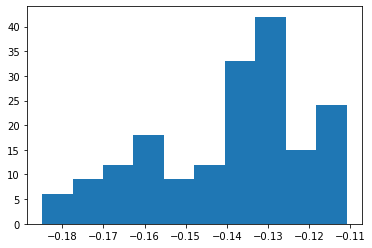

In [49]:
odds['corr'].hist(grid=False);

In [50]:
prob_hilo = []

for r in list(zip(odds['alpha_1'], odds['alpha_2'], odds['mu_1'], odds['mu_2'], odds['omega'], odds['CHL_LINE'])):
    total_count = 1. / torch.tensor(r[0:2], device='cpu') 
    logits = torch.log(torch.tensor(r[0:2], device='cpu') * torch.tensor(r[2:4], device='cpu'))
    omega = torch.tensor(r[4], device='cpu')

    bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)
    value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))
    corner = bnb_corner.log_prob(value).exp()
    
    line = r[5]
    mask = value.sum(-1) < line
    prob_lo = corner[mask].sum()
    prob_hi = 1 - prob_lo
    
    prob_hilo.append([prob_hi.item(), prob_lo.item()])

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [51]:
odds[['prob_hi', 'prob_lo']] = prob_hilo

In [52]:
odds['kelly_hi'] = (odds['prob_hi'] * odds['CHL_H'] - 1) / (odds['CHL_H'] - 1)
odds['kelly_lo'] = (odds['prob_lo'] * odds['CHL_L'] - 1) / (odds['CHL_L'] - 1)

In [53]:
odds['kelly'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], odds['kelly_hi'], odds['kelly_lo']), 
    np.nan
)

In [54]:
odds['bet'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], 'High', 'Low'), 
    None
)

In [55]:
odds = odds.sort_values('kelly', ascending=False).reset_index(drop=True)

In [56]:
odds['selected'] = np.where(
    odds['MAINLINE']==True, np.where(
        odds['kelly']>0.35, '$$$', np.where(
            odds['kelly']>0.25, '$$', np.where(
                odds['kelly']>0.15, '$', None))), 
    None
)

In [57]:
odds = odds.drop(columns=cols_pred+['kelly_hi', 'kelly_lo'])

In [58]:
odds[odds.bet.notna() & odds.selected.notna()].reset_index(drop=True)

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
0,SATFB3561,2024-03-30,23:00:00,Eng Premier [EPL],Tottenham,Luton,True,12.5,2.08,1.66,0.243896,0.756104,0.386564,Low,$$$
1,FRIFB3781,2024-03-29,23:00:00,Eng Championship [ED1],Sheff Wednesday,Swansea,True,10.5,1.98,1.73,0.271069,0.728931,0.357603,Low,$$$
2,SUNFB3840,2024-03-31,19:30:00,German Division 2 [GD2],St. Pauli,Paderborn,True,10.5,2.10,1.65,0.271887,0.728113,0.309825,Low,$$
3,SATFB3832,2024-03-30,21:00:00,Spanish Division 1 [SFL],Getafe,Sevilla,True,9.5,2.10,1.65,0.286664,0.713336,0.272315,Low,$$
4,SATFB3847,2024-03-30,22:30:00,German Division 1 [GSL],RB Leipzig,Mainz,True,10.5,1.95,1.75,0.314430,0.685570,0.266330,Low,$$
5,SUNFB3833,2024-03-31,22:15:00,Spanish Division 1 [SFL],Girona,Betis,True,10.5,2.25,1.57,0.267707,0.732293,0.262633,Low,$$
6,SATFB3845,2024-03-30,22:30:00,German Division 1 [GSL],Monchengladbach,Freiburg,True,10.5,2.07,1.67,0.312148,0.687852,0.221961,Low,$
7,FRIFB3775,2024-03-29,23:00:00,Eng Championship [ED1],Huddersfield,Coventry,True,10.5,1.85,1.85,0.368456,0.631544,0.198067,Low,$
8,SUNFB3896,2024-03-31,04:00:00,Spanish Division 1 [SFL],Barcelona,Las Palmas,True,10.5,2.13,1.63,0.324678,0.675322,0.159960,Low,$


In [59]:
display_df(odds[odds.MatchDay.isin(odds[odds.bet.notna() & odds.selected.notna()].MatchDay) & odds.bet.notna()])

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
0,FRIFB3781,2024-03-29,23:00:00,Eng Championship [ED1],Sheff Wednesday,Swansea,False,14.5,5.15,1.11,0.046777,0.953223,0.527976,Low,None
1,SATFB3561,2024-03-30,23:00:00,Eng Premier [EPL],Tottenham,Luton,False,15.5,4.15,1.17,0.075640,0.924360,0.479420,Low,None
2,SATFB3561,2024-03-30,23:00:00,Eng Premier [EPL],Tottenham,Luton,False,13.5,2.60,1.43,0.171020,0.828980,0.431260,Low,None
3,FRIFB3781,2024-03-29,23:00:00,Eng Championship [ED1],Sheff Wednesday,Swansea,False,11.5,2.45,1.48,0.186923,0.813077,0.423653,Low,None
4,SATFB3847,2024-03-30,22:30:00,German Division 1 [GSL],RB Leipzig,Mainz,False,13.5,3.95,1.19,0.097859,0.902141,0.387092,Low,None
5,SATFB3561,2024-03-30,23:00:00,Eng Premier [EPL],Tottenham,Luton,True,12.5,2.08,1.66,0.243896,0.756104,0.386564,Low,$$$
6,SUNFB3840,2024-03-31,19:30:00,German Division 2 [GD2],St. Pauli,Paderborn,False,13.5,4.60,1.14,0.077246,0.922754,0.370998,Low,None
7,SATFB3832,2024-03-30,21:00:00,Spanish Division 1 [SFL],Getafe,Sevilla,False,12.5,4.60,1.14,0.078088,0.921912,0.364144,Low,None
8,FRIFB3781,2024-03-29,23:00:00,Eng Championship [ED1],Sheff Wednesday,Swansea,True,10.5,1.98,1.73,0.271069,0.728931,0.357603,Low,$$$
9,SUNFB3833,2024-03-31,22:15:00,Spanish Division 1 [SFL],Girona,Betis,False,13.5,4.75,1.13,0.075477,0.924523,0.343930,Low,None


In [60]:
odds[odds.MAINLINE].to_csv(path_output/f'odds-{datetime.now().strftime("%Y-%m-%d")}.csv', float_format='%.2f', index=False)